Importamos Librerias

In [23]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import subprocess

In [24]:
def get_gpu_memory():
    """Returns the total memory of the GPU in MB"""
    try:
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"], 
            encoding='utf-8')
        return int(result.strip())
    except Exception as e:
        print("Error al obtener la información de la memoria de la GPU:", e)
        return None

# Obtener la cantidad de memoria VRAM disponible en la GPU
total_memory_mb = get_gpu_memory()
if total_memory_mb is not None:
    total_memory_gb = total_memory_mb / 1024
    print("Cantidad total de memoria VRAM en la GPU:", total_memory_gb, "GB")
    
    # Configurar TensorFlow para limitar el uso de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # Limitar la memoria GPU al máximo disponible
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se pudo obtener la información de la memoria de la GPU.")


Cantidad total de memoria VRAM en la GPU: 6.0 GB


Cargamos el archivo .pkl

In [25]:
df = pd.read_pickle('emotions_dataset.pkl')

Primera revision de los datos

In [26]:
df.head()

,Imagen,Imagen con zoom,Hitos faciales,Etiquetas
0,"[[[165, 166, 161], [165, 166, 161], [165, 166,...","[[[[160 162 161], [160 162 161], [160 162 161]...","[[[62, 83], [62, 88], [62, 93], [63, 97], [64,...",bored
1,"[[[164, 166, 161], [165, 167, 162], [164, 166,...","[[[[160 162 160], [161 162 161], [160 161 160]...","[[[62, 83], [62, 87], [62, 92], [63, 96], [64,...",bored
2,"[[[165, 165, 163], [165, 165, 163], [164, 165,...","[[[[159 161 158], [160 162 159], [161 162 160]...","[[[63, 82], [63, 87], [63, 91], [64, 96], [65,...",bored
3,"[[[165, 166, 162], [165, 165, 164], [165, 165,...","[[[[159 161 158], [161 163 160], [155 157 154]...","[[[63, 83], [62, 87], [63, 92], [63, 97], [65,...",bored
4,"[[[165, 166, 161], [166, 167, 162], [165, 167,...","[[[[160 162 160], [161 163 161], [152 154 151]...","[[[63, 83], [63, 87], [63, 92], [63, 96], [64,...",bored


El siguiente bloque de codigo se hace por que la funcion de FaceLandMarks no entrega arreglos de la misma longitud, es decir no encuentra la misma cantidad de puntos faciales en todos los rostros, lo cual impide la conversion a numpy Array

In [27]:
primero = np.array(df['Hitos faciales'][0]).shape

In [28]:
# Crear una nueva columna para almacenar solo los registros que cumplan con la forma deseada
df['Hitos faciales válidos'] = df['Hitos faciales'].apply(lambda x: x if np.array(x).shape == (1, 72, 2) else None)

# Eliminar los registros que no cumplen con la forma deseada
df = df.dropna(subset=['Hitos faciales válidos'])

# Convertir la columna 'Hitos faciales válidos' en un array NumPy
puntos = np.array(df['Hitos faciales'].tolist())

# Verificar la forma de X
print(puntos.shape)

(5035, 1, 72, 2)


Codificamos las etiquetas, es decir las convertimos a valores numericos

In [29]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Etiquetas'])

Verificacion de que el bloque anterior funciono jeje

In [30]:
print("Clases originales:", df['Etiquetas'].unique())
print("Clases codificadas:", label_encoder.classes_)


Clases originales: ['bored' 'engaged' 'excited' 'focused' 'interested' 'relaxed']
Clases codificadas: ['bored' 'engaged' 'excited' 'focused' 'interested' 'relaxed']


Dividimos los datos para entrenamiento y para validacion

In [31]:
X_train, X_test, y_train, y_test = train_test_split(puntos, y, test_size=0.3, random_state=42)

Creacion del modelo, la cantidad tan alta de capas se debe a la intencion de conseguir un accuracy de al menos 50%, se realizaron pruebas con distintas configuraciones siendo esta la mejor hasta el momento

In [32]:
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

# Definir la entrada del modelo
inputs = Input(shape=(1, 72, 2))

# Aplanar los datos de entrada
flatten = Flatten()(inputs)

# Capas densas
dense1 = Dense(500, activation='relu')(flatten)
dense2 = Dense(450, activation='relu')(dense1)
dense3 = Dense(400, activation='relu')(dense2)
dense4 = Dense(380, activation='relu')(dense3)
dense5 = Dense(330, activation='relu')(dense4)
dense6 = Dense(300, activation='relu')(dense5)
dense7 = Dense(280, activation='relu')(dense6)
dense8 = Dense(200, activation='relu')(dense7)
dense9 = Dense(180, activation='relu')(dense8)
dense10 = Dense(64, activation='relu')(dense9)


# Capa de salida
outputs = Dense(len(label_encoder.classes_), activation='softmax')(dense10)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Entrenamiento del modelo

In [36]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
100/100 [==============================] - 1s 11ms/step - loss: 1.2799 - accuracy: 0.4191 - val_loss: 1.3211 - val_accuracy: 0.4391
Epoch 2/50
100/100 [==============================] - 1s 8ms/step - loss: 1.2728 - accuracy: 0.4191 - val_loss: 1.3434 - val_accuracy: 0.3541
Epoch 3/50
100/100 [==============================] - 1s 8ms/step - loss: 1.2819 - accuracy: 0.4201 - val_loss: 1.3751 - val_accuracy: 0.3796
Epoch 4/50
100/100 [==============================] - 1s 8ms/step - loss: 1.2833 - accuracy: 0.4015 - val_loss: 1.3341 - val_accuracy: 0.3626
Epoch 5/50
100/100 [==============================] - 1s 8ms/step - loss: 1.2757 - accuracy: 0.4175 - val_loss: 1.3717 - val_accuracy: 0.3683
Epoch 6/50
100/100 [==============================] - 1s 8ms/step - loss: 1.2783 - accuracy: 0.4279 - val_loss: 1.3261 - val_accuracy: 0.4079
Epoch 7/50
100/100 [==============================] - 1s 8ms/step - loss: 1.2706 - accuracy: 0.4289 - val_loss: 1.3578 - val_accuracy: 0.4136
Epoch

Despues de varias pruebas el accuracy maximo alcanzado fue de 45% con 150 epocas de entrenamiento, esto se atribuye al desbalance de las clases y el como se dividieron los datos 

#####

Realice una ultima prueba con 6 epocas consiguiendo un 47% de accuracy                                                                                                                                                                                                                                                                                                                                                        48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4907 - loss: 1.1949
Loss: 1.217307209968567, Accuracy: 0.47452017664909363

In [34]:
# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

15/48 [========>.....................] - ETA: 0s - loss: 1.2929 - accuracy: 0.3979

48/48 [==============================] - 0s 5ms/step - loss: 1.2920 - accuracy: 0.4050
Loss: 1.2920198440551758, Accuracy: 0.4050297737121582


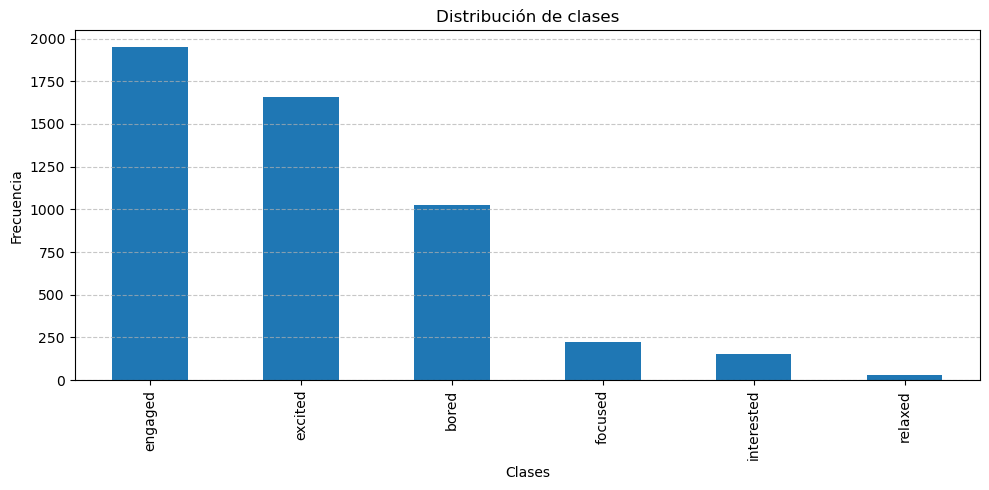

In [35]:
etiquetas = df.iloc[:, 3]
conteo_clases = etiquetas.value_counts()

plt.figure(figsize=(10, 5))
conteo_clases.plot(kind='bar')
plt.title('Distribución de clases')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.xticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()